In [3]:
import pandas as pd

In [4]:
# Load data
data = pd.read_csv('beer_production.csv', parse_dates=['Month'], index_col='Month')

In [5]:
data.columns = ['Production']

In [6]:
print(data.head())

            Production
Month                 
1956-01-01        93.2
1956-02-01        96.0
1956-03-01        95.2
1956-04-01        77.1
1956-05-01        70.9


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB
None


In [8]:
print(data.isnull().sum())

Production    0
dtype: int64


In [9]:
import matplotlib.pyplot as plt

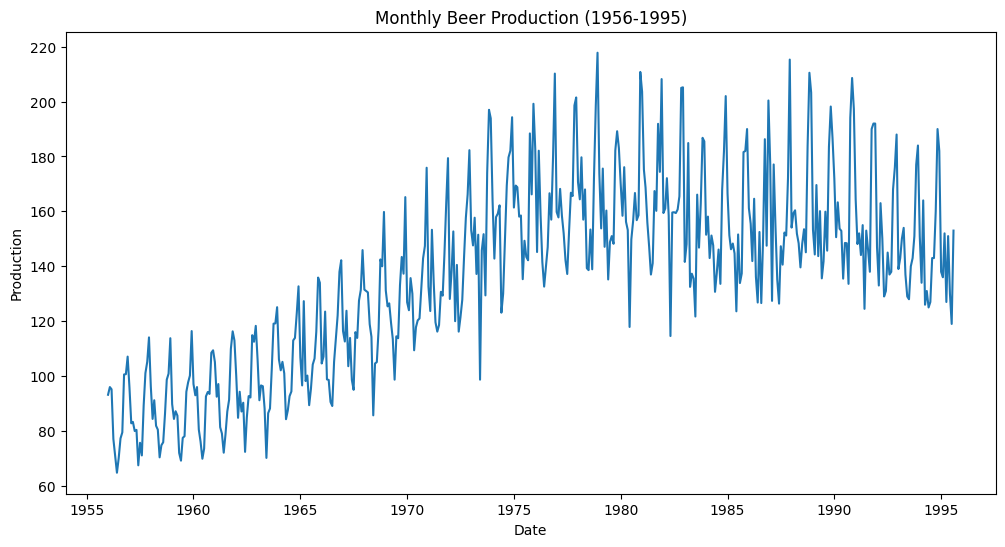

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('Monthly Beer Production (1956-1995)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.show()

In [11]:
from statsmodels.tsa.seasonal import STL

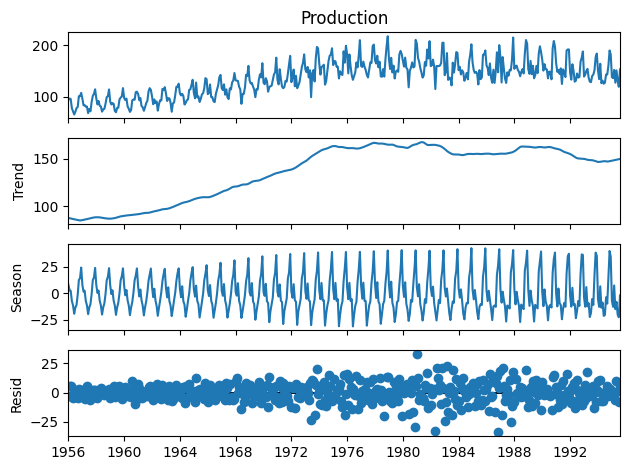

In [12]:
decomposition = STL(data['Production'], seasonal=13).fit()
decomposition.plot()
plt.show()

Augmented Dickey-Fuller (ADF) Test:

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
result = adfuller(data['Production'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.282661418787577
p-value: 0.17762099829132505


### **ADF Test Results** *ADF Statistic* : -2.28  *p-value* : 0.178  
### Interpretation
- As the p-value > 0.05, it indicates **failure to reject the null hypothesis** of the ADF test.  So the data is **non-stationary**.  

- As the data is non-stationary, I will Consider differencing or transforming the data to achieve stationarity for further analysis.

In [15]:
# Differencing
data['Production_diff'] = data['Production'].diff().dropna()

In [16]:
# ADF Test on differenced data
result = adfuller(data['Production_diff'].dropna())
print('ADF Statistic (Differenced):', result[0])
print('p-value (Differenced):', result[1])

ADF Statistic (Differenced): -4.980663743064638
p-value (Differenced): 2.4234117859977578e-05


### Differenced ADF Test Results
- **ADF Statistic (Differenced)**: -4.98  
- **p-value (Differenced)**: 2.42e-05  

### Interpretation
- Now after differencing the p-value < 0.05, which indicates **strong evidence to reject the null hypothesis** of the ADF test.  
- The differenced time series is now **stationary**.  

- Differencing successfully removed the non-stationarity, making the data suitable for further time series analysis.

In [17]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

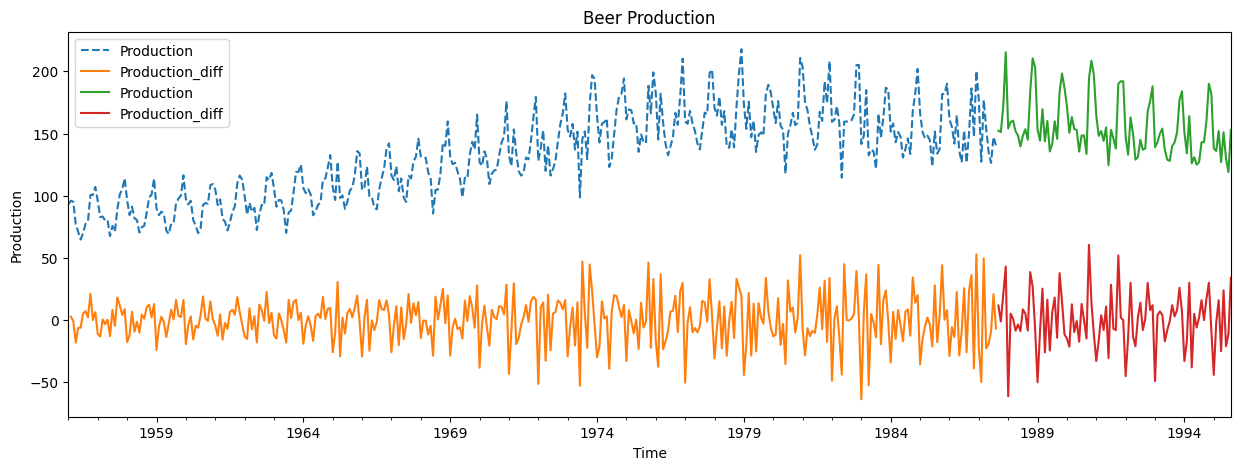

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine train and test sets
combined_data = pd.concat([train, test], axis=1)

# Plot the combined data
combined_data.plot(figsize=(15, 5), title='Beer Production', style=['--', '-'])
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend()
plt.show()


In [19]:
print(train.index.intersection(test.index))

DatetimeIndex([], dtype='datetime64[ns]', name='Month', freq=None)


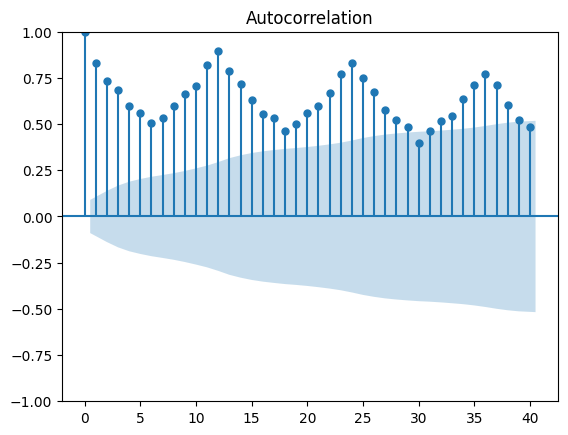

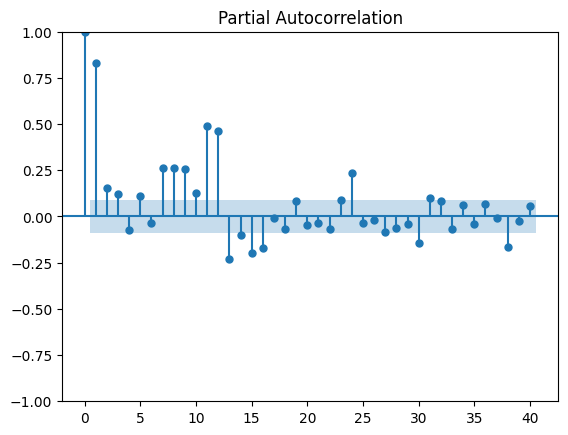

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Production'], lags=40)
plt.show()

plot_pacf(data['Production'], lags=40)
plt.show()

In [21]:
import itertools
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [23]:
# Define parameter ranges for grid search
p = d = q = range(0, 3)   # Non-seasonal orders (p, d, q)
P = D = Q = range(0, 2)   # Seasonal orders (P, D, Q)
s = 12  # Seasonal period (12 for monthly data)

In [24]:
# Generate all combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

In [25]:
# Initialize variables to store the best model details
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

In [26]:
# Grid search with progress tracking
total_combinations = len(pdq) * len(seasonal_pdq)
print(f"Total SARIMA combinations to test: {total_combinations}")

Total SARIMA combinations to test: 216


In [27]:
for i, param in enumerate(pdq):
    for seasonal_param in seasonal_pdq:
        try:
            print(f"Testing SARIMA{param}x{seasonal_param} ({i+1}/{total_combinations})", end="\r")

            # Fit SARIMA model
            model = SARIMAX(train['Production'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # Check if the current model is the best
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
                best_model = results

        except Exception as e:
            print(f"Error with SARIMA{param}x{seasonal_param}: {e}")
            continue

In [28]:
# Output the best parameters
print("\nBest SARIMA Model:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal_order}")
print(f"AIC: {best_aic}")


Best SARIMA Model:
Order: (1, 1, 2)
Seasonal Order: (1, 1, 1, 12)
AIC: 2619.5553704077693


In [29]:
# Forecast using the best model
predictions = best_model.forecast(steps=len(test))

In [30]:
# Evaluate the model
mse = mean_squared_error(test['Production'], predictions)
mae = mean_absolute_error(test['Production'], predictions)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 167.78
Mean Absolute Error (MAE): 10.28


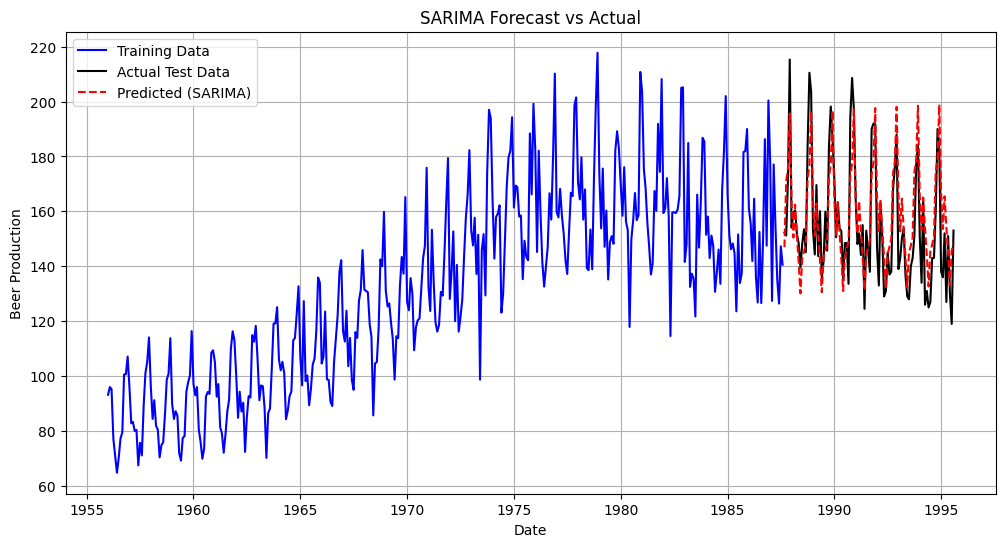

In [31]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Production'], label='Training Data', color='blue')
plt.plot(test.index, test['Production'], label='Actual Test Data', color='black')
plt.plot(test.index, predictions, label='Predicted (SARIMA)', color='red', linestyle='dashed')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Beer Production')
plt.legend()
plt.grid()
plt.show()